In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_fscore_support,roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.utils import resample
import seaborn as sns


# Part A: Data Exploration and Baseline Model 

## 1. Load and Analyze the Dataset

In [2]:
df = pd.read_csv("creditcard.csv")   # ensure file is in working dir
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Quick peek
display(df.head())

Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Analyze Class Distribution

In [3]:
class_counts = df['Class'].value_counts().sort_index()
total = class_counts.sum()
fraud_count = class_counts.loc[1]
nonfraud_count = class_counts.loc[0]
fraud_pct = fraud_count / total * 100
nonfraud_pct = nonfraud_count / total * 100

print(f"Non-fraudulent (Class=0): {nonfraud_count} ({nonfraud_pct:.4f}%)")
print(f"Fraudulent     (Class=1): {fraud_count} ({fraud_pct:.4f}%)")
print(f"Imbalance ratio (non-fraud : fraud) = {nonfraud_count} : {fraud_count}  (approx {nonfraud_count/fraud_count:.0f}:1)")


Non-fraudulent (Class=0): 284315 (99.8273%)
Fraudulent     (Class=1): 492 (0.1727%)
Imbalance ratio (non-fraud : fraud) = 284315 : 492  (approx 578:1)


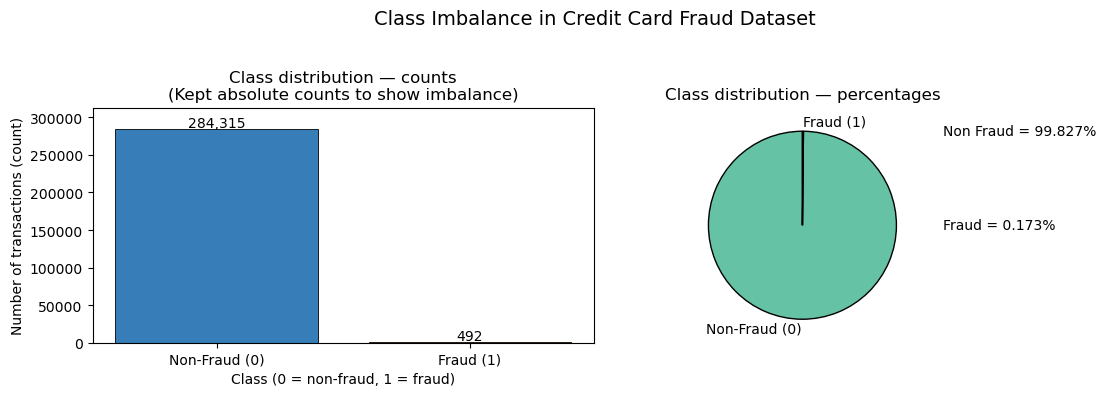



Plot description: The dataset is extremely imbalanced — fraud is a tiny fraction of all transactions.
 Seven commandments applied: colorblind-safe palette, labeled axes, scale noted, legend/pct in pie, title + description.


In [4]:

palette = ['#377eb8', '#ff7f00']  
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Bar
axes[0].bar(['Non-Fraud (0)', 'Fraud (1)'], [nonfraud_count, fraud_count], color=palette, edgecolor='k', linewidth=0.6)
axes[0].set_title("Class distribution — counts\n(Kept absolute counts to show imbalance)", fontsize=12)
axes[0].set_xlabel("Class (0 = non-fraud, 1 = fraud)")
axes[0].set_ylabel("Number of transactions (count)")
axes[0].set_yscale('linear')  
ymax = max(nonfraud_count, fraud_count) * 1.1   # add 5% padding
axes[0].set_ylim(0, ymax)
axes[0].annotate(f"{nonfraud_count:,}", xy=(0, nonfraud_count), xytext=(0, nonfraud_count*1.01), ha='center')
axes[0].annotate(f"{fraud_count:,}", xy=(1, fraud_count), xytext=(1, fraud_count*7), ha='center')

axes[1].set_title("Class distribution — percentages", fontsize=12)

axes[1].pie(
    [nonfraud_count, fraud_count],
    labels=['Non-Fraud (0)', 'Fraud (1)'],
    colors=["#66c2a5","#fc8d62"],
    startangle=90,
    wedgeprops={'edgecolor':'k'}
)

axes[1].text(1.5, 0, f"Fraud = {fraud_pct:.3f}%", ha='left', va='center', fontsize=10)
axes[1].text(1.5, 1, f"Non Fraud = {nonfraud_pct:.3f}%", ha='left', va='center', fontsize=10)


fig.suptitle("Class Imbalance in Credit Card Fraud Dataset", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])

plt.show()
print( "\n\nPlot description: The dataset is extremely imbalanced — fraud is a tiny fraction of all transactions.\n Seven commandments applied: colorblind-safe palette, labeled axes, scale noted, legend/pct in pie, title + description.")


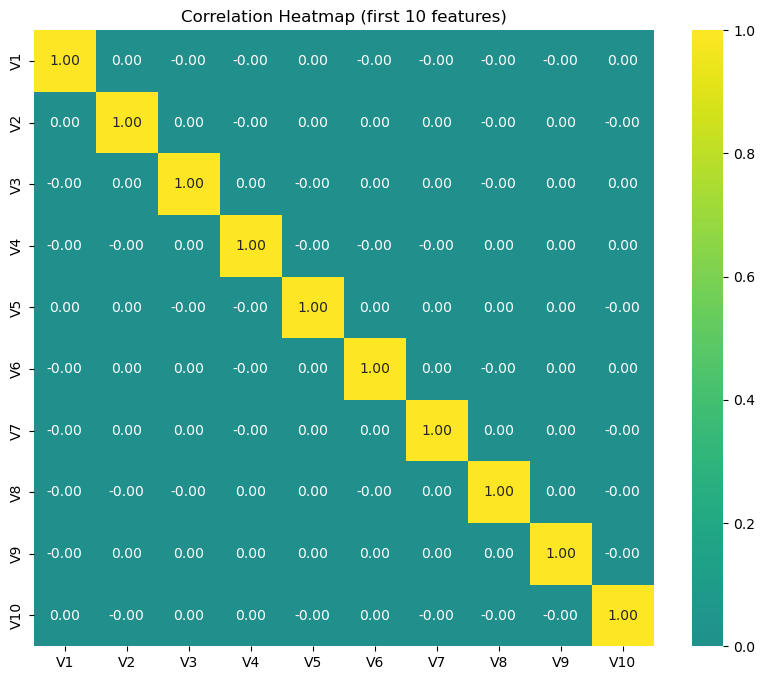

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(
    df.corr().iloc[1:11, 1:11],
    cmap="viridis",    # change color map here
    center=0,
    annot=True,        # optional: show the correlation values
    fmt=".2f"          # format numbers if annot=True
)
plt.title("Correlation Heatmap (first 10 features)")
plt.show()



The dataset demonstrates a **severe class imbalance**:

- **Non-fraudulent transactions (Class 0):** 284,315 (~99.83%)
- **Fraudulent transactions (Class 1):** 492 (~0.17%)
- **Imbalance ratio:** ~578 : 1 (non-fraud : fraud)

### Why This Is a Problem
- A model trained directly on this data could achieve **>99% accuracy** simply by always predicting *non-fraud*, yet it would **miss almost all fraudulent cases**.
- Loss functions (e.g., cross-entropy) become **dominated by the majority class**, leading to poor recall for fraud detection.
- Fraudulent patterns are extremely rare, so the model requires **balanced learning** to recognize them.

### Why Sampling Is Necessary
Resampling techniques address the imbalance by either **increasing minority samples** (oversampling) or **reducing majority samples** (undersampling).  
This helps the model:
- Pay equal attention to fraud and non-fraud classes.
- Improve **recall and F1-score**, which are more meaningful than raw accuracy for fraud detection.

### Expected Effects After Sampling
- **Balanced Training Data:** Enables the classifier to learn fraud-specific patterns.
- **Higher Recall:** More fraudulent transactions are correctly identified.
- **Slightly Lower Precision:** Possible small rise in false positives, but acceptable in high-risk domains like fraud detection.
- **Better Overall Metrics:** F1-score and ROC-AUC improve, giving a more reliable and actionable fraud detection system.

> **Key Takeaway:**  
> Proper sampling (e.g., SMOTE) is crucial for building a robust model that detects fraud effectively, rather than merely optimizing for overall accuracy.


## 3. Baseline Model

In [6]:
# Features and labels
X = df.drop(columns=['Class'])
y = df['Class']

# Note: dataset already uses PCA (V1..V28). It's good to scale Amount (and maybe Time) for logistic regression.
# We'll scale Amount and Time; the PCA features are already centered by the original preprocessing.
scaler = StandardScaler()
X_scaled = X.copy()
if 'Amount' in X.columns:
    X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])
if 'Time' in X.columns:
    # Optionally scale Time too
    X_scaled['Time'] = scaler.fit_transform(X[['Time']])

# Split ensuring the test set preserves original imbalance.
# Use stratify=y so both train and test keep the same class proportion as the full dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))



Train shape: (213605, 30) Test shape: (71202, 30)

Train class distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Test class distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64



Classification Report:
                precision    recall  f1-score   support

Non-Fraud (0)     0.9994    0.9998    0.9996     71079
    Fraud (1)     0.8462    0.6260    0.7196       123

     accuracy                         0.9992     71202
    macro avg     0.9228    0.8129    0.8596     71202
 weighted avg     0.9991    0.9992    0.9991     71202

Fraud (class=1) — Precision: 0.8462, Recall: 0.6260, F1-score: 0.7196

Overall accuracy: 0.9992

NOTE: With a highly imbalanced dataset, a classifier that always predicts 'non-fraud' would still achieve very high accuracy.
Always prefer precision, recall, F1 (especially recall for catching fraud) and confusion matrix for class-imbalanced tasks.


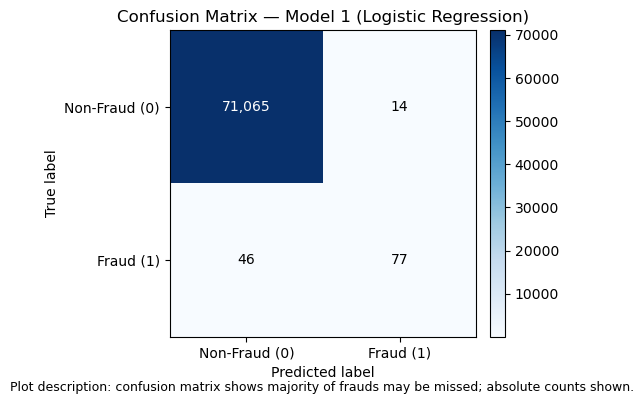

In [7]:

# Baseline logistic regression model on imbalanced training data (Model 1)
model1 = LogisticRegression(max_iter=1000, solver='liblinear')  
model1.fit(X_train, y_train)

# Predictions & evaluation
y_pred = model1.predict(X_test)
y_proba = model1.predict_proba(X_test)[:,1]


report = classification_report(y_test, y_pred, digits=4, target_names=['Non-Fraud (0)', 'Fraud (1)'])
print("\nClassification Report:\n", report)

# Compute precision/recall/f1 specifically for the fraud class
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1], average='binary')
print(f"Fraud (class=1) — Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# Accuracy (for demonstration why it's misleading)
accuracy = (y_pred == y_test).mean()
print(f"\nOverall accuracy: {accuracy:.4f}")
print("\nNOTE: With a highly imbalanced dataset, a classifier that always predicts 'non-fraud' would still achieve very high accuracy.")
print("Always prefer precision, recall, F1 (especially recall for catching fraud) and confusion matrix for class-imbalanced tasks.")
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix — Model 1 (Logistic Regression)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1]); ax.set_xticklabels(['Non-Fraud (0)','Fraud (1)'])
ax.set_yticks([0,1]); ax.set_yticklabels(['Non-Fraud (0)','Fraud (1)'])
# annotate

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]:,}", ha="center", va="center",
                color="white" if cm[i,j] > thresh else "black")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.figtext(0.5, 0.01,
            "Plot description: confusion matrix shows majority of frauds may be missed; absolute counts shown.",
            ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Part B: Resampling Approaches

## 1 Naive Oversampling
##  Resampling Approaches — SMOTE

###  What is SMOTE?
SMOTE (**Synthetic Minority Over-sampling Technique**) is an advanced oversampling method designed to handle class imbalance problems.  
Instead of simply duplicating minority class samples (frauds), SMOTE generates **synthetic samples** by interpolating between existing minority examples and their nearest neighbors.  

**How it works:**
1. For each minority-class instance, SMOTE finds its *k nearest neighbors* (typically `k=5`).
2. One neighbor is randomly chosen.
3. A new synthetic sample is created along the line segment between the instance and the neighbor:  
   $
   x_{new} = x_i + \delta \times (x_{neighbor} - x_i), \quad \delta \in [0,1]
   $
4. This process is repeated until the minority class is balanced with the majority class.

By creating synthetic points **inside the feature space**, SMOTE helps the classifier generalize better than naive oversampling.

---

###  Why use SMOTE here?
- Our dataset is **extremely imbalanced** (fraud ≈ 0.17% of transactions).
- Logistic Regression trained on this imbalance tends to **ignore the fraud class**.
- SMOTE balances the training set, enabling the model to **learn patterns of fraud more effectively**.

---

###  Limitations of SMOTE
While powerful, SMOTE has some potential drawbacks:
- **Noisy synthetic samples**: If frauds are scattered or overlap with non-frauds, SMOTE may generate unrealistic points.
- **Boundary issues**: Synthetic frauds near the class boundary might confuse the classifier.
- **High dimensionality**: With many features (like 28 PCA components), nearest-neighbor calculations may be less reliable.
- **Computational cost**: Balancing classes increases dataset size, so training becomes heavier.
- **Does not fix test imbalance**: The test set remains imbalanced (as it should), so evaluation metrics must still focus on Precision, Recall, and F1 rather than Accuracy.

---

###  Expected Impact
- **Recall (Sensitivity)** for fraud improves significantly → the model catches more fraudulent cases.
- **Precision** may drop slightly → more false positives are introduced.
- **F1-score** (balance between precision & recall) usually improves, showing a better trade-off.

---



In [8]:

# Apply SMOTE on training data
print("\nBefore SMOTE: training class distribution")
print(y_train.value_counts())

smote = SMOTE(random_state=42, sampling_strategy=1.0)  # balance minority = majority
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE: training class distribution")
print(y_train_smote.value_counts())



Before SMOTE: training class distribution
Class
0    213236
1       369
Name: count, dtype: int64

After SMOTE: training class distribution
Class
0    213236
1    213236
Name: count, dtype: int64


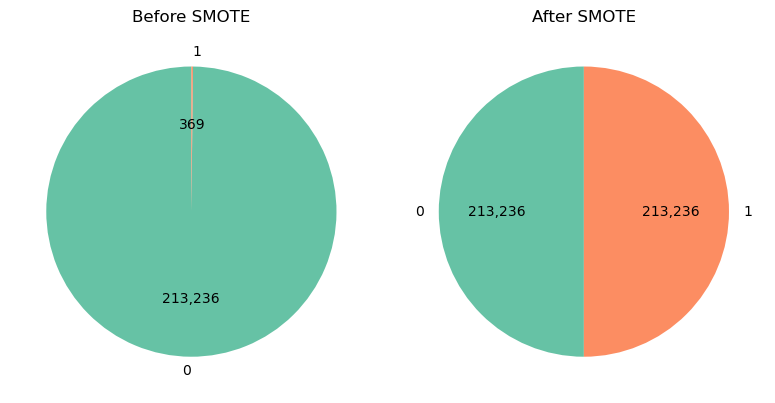

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

def absolute_count(values):
    total = sum(values)
    def formatter(pct):
        count = int(round(pct * total / 100.0))
        return f"{count:,d}"       
    return formatter

ax[0].pie(
    y_train.value_counts(),
    labels=y_train.value_counts().index,
    autopct=absolute_count(y_train.value_counts()),
    startangle=90,
    colors=["#66c2a5", "#fc8d62"]
)
ax[0].set_title("Before SMOTE")

ax[1].pie(
    y_train_smote.value_counts(),
    labels=y_train_smote.value_counts().index,
    autopct=absolute_count(y_train_smote.value_counts()),
    startangle=90,
    colors=["#66c2a5", "#fc8d62"]
)
ax[1].set_title("After SMOTE")

plt.tight_layout()
plt.show()


## 2. Clustering-Based Oversampling (CBO):


### Concept  
Clustering-Based Oversampling is an approach to handle **class imbalance** by first
discovering *natural sub-groups* in the **minority class** before oversampling.  
Instead of creating synthetic points across the entire minority space (as SMOTE does),
CBO ensures that **each cluster of the minority data is equally represented** in the final
training set.

### How It Works
1. **Cluster Minority Data**  
   * Apply a clustering algorithm (commonly **K-Means**) only to the minority-class samples.  
   * The number of clusters *k* can be chosen by intuition or techniques such as the
     **Elbow Method** or **Silhouette Score**.
2. **Balanced Oversampling within Clusters**  
   * For each cluster, oversample (randomly duplicate) points until each cluster
     contributes proportionally to match the majority class size.
   * This preserves the natural diversity of the minority distribution.
3. **Combine & Train**  
   * Merge the oversampled minority clusters with the original majority data
     to create a **balanced dataset** for model training.

### Advantages
* **Diversity Preservation** – ensures that small but important sub-populations
  of fraud cases are not drowned out.
* **Reduced Noise** – synthetic points are drawn only from real minority regions,
  lowering the risk of placing samples in empty feature space.
* **Improved Decision Boundaries** – classifiers learn a more faithful picture of
  minority patterns.

### Limitations
* **Choosing k**:  
  * Too few clusters may merge distinct patterns and hide diversity.  
  * Too many clusters can create very small groups and cause overfitting.
* **Cluster Quality**:  
  * If minority data are not well separable, clustering may be unstable.

### Evaluation
After oversampling, we train a Logistic Regression model on the
balanced data and evaluate it on the **original, imbalanced test set**.
A **confusion matrix** visually shows improvements in recall for the fraud class
while monitoring false positives.

> **Key Takeaway:**  
> CBO improves minority-class representation and often yields better recall
> than naïve oversampling, while maintaining realistic decision boundaries.


In [10]:
# Separate minority class
X_minority = X_train[y_train == 1]

# Choose number of clusters (k) – using Elbow or intuition; here we pick 3 for demo
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_minority)

# Oversample each cluster to match majority class size
X_resampled_list = []
y_resampled_list = []
maj_count = y_train.value_counts()[0]

for c in range(k):
    cluster_points = X_minority[cluster_labels == c]
    cluster_size = len(cluster_points)

    # Proportionate oversampling to reach majority size/k per cluster
    n_samples = int(maj_count / k)
    X_over = resample(cluster_points,
                      replace=True,
                      n_samples=n_samples,
                      random_state=42)
    y_over = np.ones(len(X_over))  # label = 1
    X_resampled_list.append(X_over)
    y_resampled_list.append(y_over)

# Combine with majority class
X_majority = X_train[y_train == 0]
y_majority = np.zeros(len(X_majority))

X_train_cbo = np.vstack([X_majority] + X_resampled_list)
y_train_cbo = np.hstack([y_majority] + y_resampled_list)

print("\nBefore CBO: training class distribution")
print(y_train.value_counts())

print("\nClass distribution after CBO:")
print(pd.Series(y_train_cbo).value_counts())



Before CBO: training class distribution
Class
0    213236
1       369
Name: count, dtype: int64

Class distribution after CBO:
0.0    213236
1.0    213234
Name: count, dtype: int64


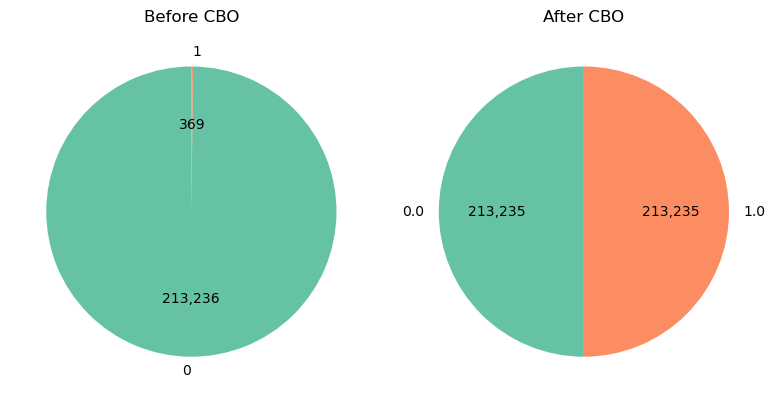

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

def absolute_count(values):
    total = sum(values)
    def formatter(pct):
        count = int(round(pct * total / 100.0))
        return f"{count:,d}"       
    return formatter

ax[0].pie(
    y_train.value_counts(),
    labels=y_train.value_counts().index,
    autopct=absolute_count(y_train.value_counts()),
    startangle=90,
    colors=["#66c2a5", "#fc8d62"]
)
ax[0].set_title("Before CBO")

ax[1].pie(
    y_train_smote.value_counts(),
    labels=pd.Series(y_train_cbo).value_counts().index,
    autopct=absolute_count(pd.Series(y_train_cbo).value_counts()),
    startangle=90,
    colors=["#66c2a5", "#fc8d62"]
)
ax[1].set_title("After CBO")

plt.tight_layout()
plt.show()


## 3. Clustering-Based Undersampling (CBU)

### Concept  
Clustering-Based Undersampling is a technique to address **class imbalance** by
**strategically reducing** the size of the **majority class** while preserving its
diversity.  
Instead of randomly discarding majority samples—which can remove important
patterns—CBU first discovers **natural sub-groups** (clusters) within the majority
class and then undersamples within each cluster.

### How It Works
1. **Cluster the Majority Class**  
   * Apply a clustering algorithm (commonly **K-Means**) to the **majority-class data only**.
   * The number of clusters *k* can be chosen via the **Elbow Method**, **Silhouette
     score**, or domain knowledge.

2. **Cluster-Aware Undersampling**  
   * **Option A – Proportional:** Randomly select samples from each cluster
     **proportional to the cluster’s size**, ensuring the final set reflects the
     original distribution of the majority class.
   * **Option B – Distance-Based:** Preferentially remove samples from clusters that
     are **closest to the minority class** in feature space, which can help sharpen
     the decision boundary.

3. **Combine with Minority Class**  
   * Keep **all minority samples** intact.
   * Merge them with the **reduced majority subset** to create a **balanced training
     dataset**.

### Advantages
* **Preserves Diversity** – Each majority sub-group remains represented.
* **Reduces Redundant Data** – Fewer samples mean lower training time and less
  storage without significant loss of information.
* **Improved Decision Boundaries** – By removing majority points near the
  minority space, classifiers may better capture minority patterns.

### Limitations
* **Choice of k:** Too few clusters can merge distinct majority patterns;
  too many can yield tiny clusters that are hard to sample from.
* **Clustering Quality:** If the majority class has complex structure,
  clustering might not fully capture all sub-patterns.

### Key Takeaway  
CBU combats class imbalance by **intelligently shrinking** the majority class.
By undersampling within well-defined clusters, it retains the
representative structure of the majority data while giving the
classifier a more balanced training set.


In [12]:


#  Separate majority and minority classes
X_majority = X_train[y_train == 0]
X_minority = X_train[y_train == 1]

# Choose number of clusters for majority class
k = 5  # you can tune with Elbow or Silhouette methods
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_majority)

#  Decide final majority size (same as minority size for full balance here)
target_maj_count = len(X_minority)

# We will draw from each cluster proportional to its size
X_undersampled_list = []
y_undersampled_list = []

for c in range(k):
    cluster_points = X_majority[cluster_labels == c]
    cluster_size = len(cluster_points)
    # proportion of cluster relative to all majority
    cluster_ratio = cluster_size / len(X_majority)
    n_samples = int(cluster_ratio * target_maj_count)

    X_under = resample(cluster_points,
                       replace=False,    # no replacement: true undersampling
                       n_samples=n_samples,
                       random_state=42)
    y_under = np.zeros(len(X_under))
    X_undersampled_list.append(X_under)
    y_undersampled_list.append(y_under)

# Combine undersampled majority with all minority samples
X_train_cbu = np.vstack([X_minority] + X_undersampled_list)
y_train_cbu = np.hstack([np.ones(len(X_minority))] + y_undersampled_list)

print("\nBefore CBU: training class distribution")
print(y_train.value_counts())

print("\nClass distribution after CBU:")
print(pd.Series(y_train_cbu).value_counts())



Before CBU: training class distribution
Class
0    213236
1       369
Name: count, dtype: int64

Class distribution after CBU:
1.0    369
0.0    366
Name: count, dtype: int64


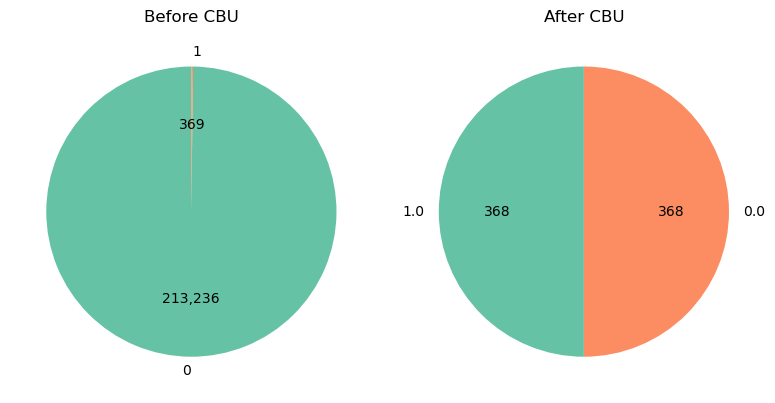

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

def absolute_count(values):
    total = sum(values)
    def formatter(pct):
        count = int(round(pct * total / 100.0))
        return f"{count:,d}"       
    return formatter

ax[0].pie(
    y_train.value_counts(),
    labels=y_train.value_counts().index,
    autopct=absolute_count(y_train.value_counts()),
    startangle=90,
    colors=["#66c2a5", "#fc8d62"]
)
ax[0].set_title("Before CBU")

ax[1].pie(
    y_train_smote.value_counts(),
    labels=pd.Series(y_train_cbu).value_counts().index,
    autopct=absolute_count(pd.Series(y_train_cbu).value_counts()),
    startangle=90,
    colors=["#66c2a5", "#fc8d62"]
)
ax[1].set_title("After CBU")

plt.tight_layout()
plt.show()


# Part C: Model Comparison and Analysis

## 1. Train and Evaluate Models

In [14]:
def evaluate_model(name, model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    # For ROC we need predicted probabilities for the positive class
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError(
            f"{name} does not support probability/decision_function output for ROC."
        )

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n==== {name} ====")
    print(classification_report(
        y_test, y_pred, digits=4,
        target_names=['Non-Fraud (0)', 'Fraud (1)']
    ))
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=[1], average='binary'
    )
    print(f"Fraud (1) → Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # ----- Plot confusion matrix -----
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))

    im = ax[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
    ax[0].set_title(f"Confusion Matrix — {name}")
    ax[0].set_xlabel("Predicted label")
    ax[0].set_ylabel("True label")
    ax[0].set_xticks([0, 1]); ax[0].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'])
    ax[0].set_yticks([0, 1]); ax[0].set_yticklabels(['Non-Fraud (0)', 'Fraud (1)'])
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[0].text(j, i, f"{cm[i, j]}",
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")
    fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

    # ----- Plot ROC curve -----
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)

    ax[1].plot(fpr, tpr, color="darkorange",
               lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
    ax[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title(f"ROC Curve — {name}")
    ax[1].legend(loc="lower right")

    plt.figtext(0.5, 0.01,
                f"{name}: Performance on imbalanced test set.",
                ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()



==== Model 2 – Logistic Regression + SMOTE ====
               precision    recall  f1-score   support

Non-Fraud (0)     0.9998    0.9758    0.9877     71079
    Fraud (1)     0.0597    0.8862    0.1118       123

     accuracy                         0.9757     71202
    macro avg     0.5297    0.9310    0.5497     71202
 weighted avg     0.9982    0.9757    0.9862     71202

Fraud (1) → Precision: 0.0597, Recall: 0.8862, F1: 0.1118


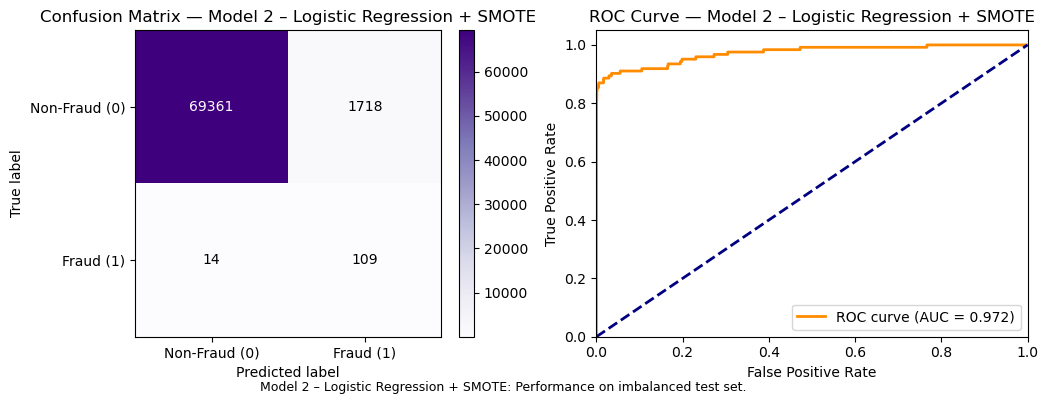

/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



==== Model 3 – Logistic Regression + CBO ====
               precision    recall  f1-score   support

Non-Fraud (0)     0.9998    0.9878    0.9938     71079
    Fraud (1)     0.1111    0.8780    0.1973       123

     accuracy                         0.9877     71202
    macro avg     0.5554    0.9329    0.5955     71202
 weighted avg     0.9983    0.9877    0.9924     71202

Fraud (1) → Precision: 0.1111, Recall: 0.8780, F1: 0.1973


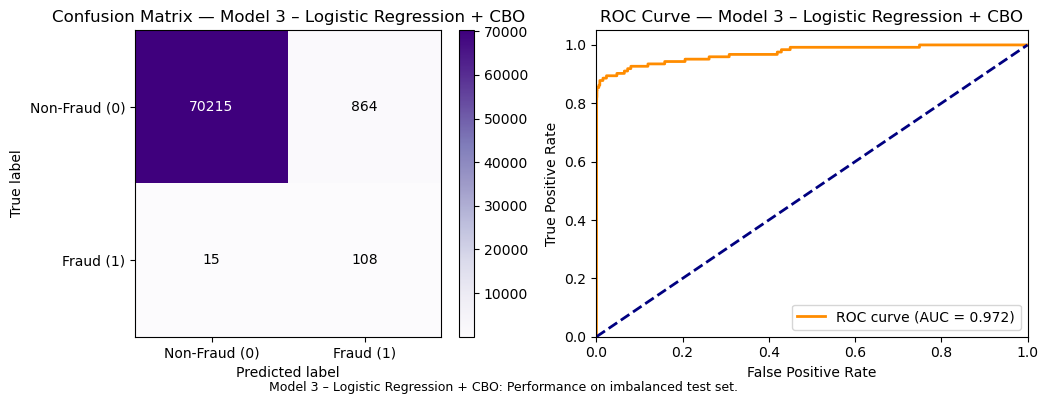

/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



==== Model 4 – Logistic Regression + CBU ====
               precision    recall  f1-score   support

Non-Fraud (0)     0.9998    0.9661    0.9827     71079
    Fraud (1)     0.0433    0.8862    0.0825       123

     accuracy                         0.9660     71202
    macro avg     0.5215    0.9261    0.5326     71202
 weighted avg     0.9981    0.9660    0.9811     71202

Fraud (1) → Precision: 0.0433, Recall: 0.8862, F1: 0.0825


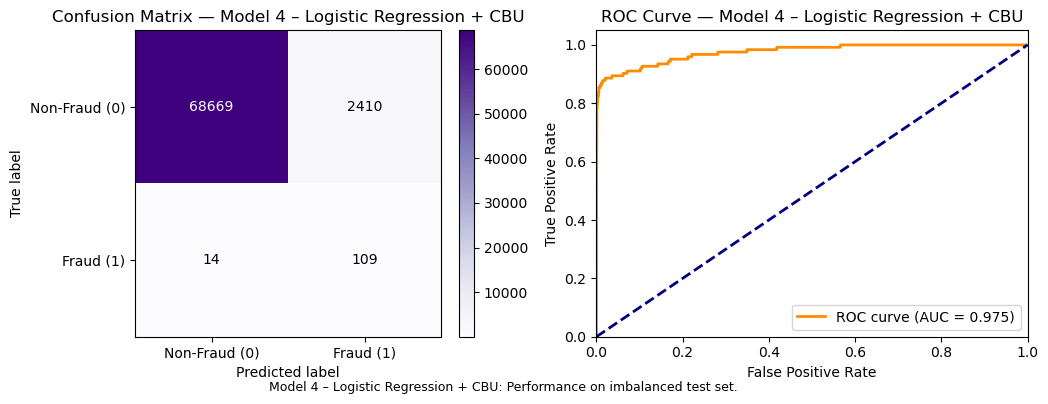

In [15]:
# ---------- Model 2: SMOTE ----------
sm = SMOTE(random_state=42)
model_smote = LogisticRegression(max_iter=1000, solver='liblinear')
model_smote.fit(X_train_smote, y_train_smote)
evaluate_model("Model 2 – Logistic Regression + SMOTE", model_smote, X_test, y_test)

# ---------- Model 3: Clustering-Based Oversampling (CBO) ----------
model_cbo = LogisticRegression(max_iter=1000, solver='liblinear')
model_cbo.fit(X_train_cbo, y_train_cbo)
evaluate_model("Model 3 – Logistic Regression + CBO", model_cbo, X_test, y_test)

# ---------- Model 4: Clustering-Based Undersampling (CBU) ----------
model_cbu = LogisticRegression(max_iter=1000, solver='liblinear')
model_cbu.fit(X_train_cbu, y_train_cbu)
evaluate_model("Model 4 – Logistic Regression + CBU", model_cbu, X_test, y_test)


## 2 Performance Comparison

Below is a comparison of **Precision**, **Recall**, and **F1-score** for the **minority class (Fraud = 1)** across all four models.

| Model | Precision | Recall | F1-score |
|------|----------|-------|---------|
| **Model 1 – Baseline** | **0.8462** | 0.6260 | 0.7196 |
| **Model 2 – SMOTE**    | 0.0597 | **0.8862** | 0.1118 |
| **Model 3 – CBO**      | 0.1111 | 0.8780 | **0.1973** |
| **Model 4 – CBU**      | 0.0433 | 0.8862 | 0.0825 |

### Key Insights
- **Baseline**: Highest precision (0.8462) but low recall (0.6260), meaning it rarely predicts fraud but is very accurate when it does.
- **SMOTE**: Massive recall gain (0.8862) but extremely low precision (0.0597), leading to many false positives.
- **CBO**: Better balance than SMOTE with slightly higher precision (0.1111) and good recall (0.8780).
- **CBU**: Similar to SMOTE in recall (0.8862) but lowest precision (0.0433).

> **Trade-off**: Resampling boosts recall (catching more fraud) at the expense of precision (more false alarms).

---

## 📈 Bar Chart Visualization
The following Python code creates a grouped bar chart comparing **Precision**, **Recall**, and **F1-score** across all models.




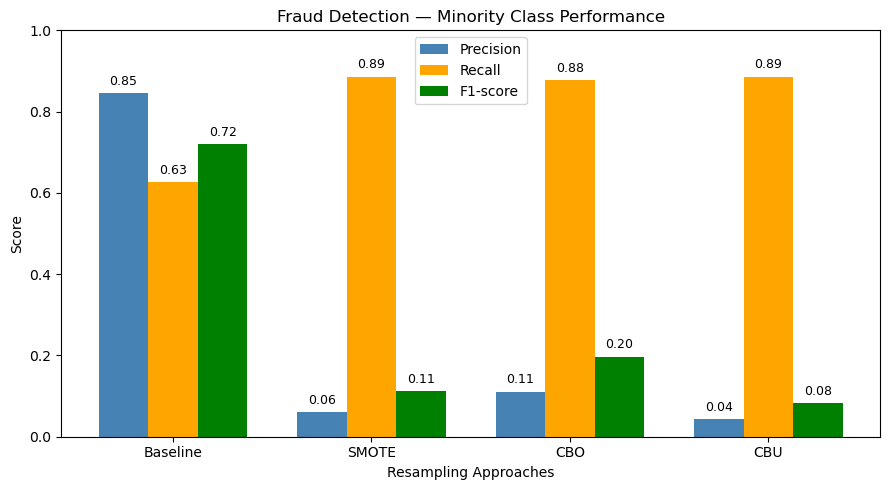

In [16]:

# Metrics for Fraud (class 1)
models = ['Baseline', 'SMOTE', 'CBO', 'CBU']
precision = [0.8462, 0.0597, 0.1111, 0.0433]
recall    = [0.6260, 0.8862, 0.8780, 0.8862]
f1_score  = [0.7196, 0.1118, 0.1973, 0.0825]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x - width, precision, width, label='Precision', color='steelblue')
ax.bar(x, recall, width, label='Recall', color='orange')
ax.bar(x + width, f1_score, width, label='F1-score', color='green')

ax.set_ylabel('Score')
ax.set_xlabel('Resampling Approaches')
ax.set_title('Fraud Detection — Minority Class Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

for i, v in enumerate(precision):
    ax.text(i - width, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)
for i, v in enumerate(recall):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)
for i, v in enumerate(f1_score):
    ax.text(i + width, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


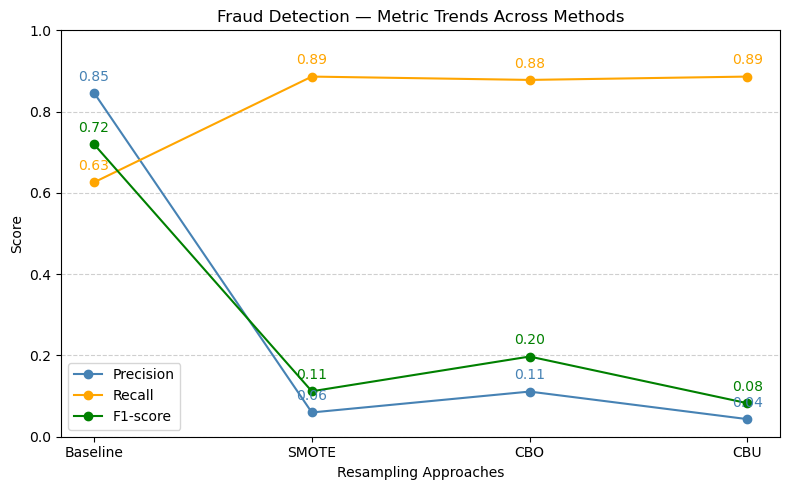

In [17]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(models, precision, marker='o', color='steelblue', label='Precision')
ax.plot(models, recall, marker='o', color='orange', label='Recall')
ax.plot(models, f1_score, marker='o', color='green', label='F1-score')

ax.set_title("Fraud Detection — Metric Trends Across Methods")
ax.set_ylabel("Score")
ax.set_xlabel("Resampling Approaches")
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

for x_val, p, r, f in zip(models, precision, recall, f1_score):
    ax.text(x_val, p + 0.03, f"{p:.2f}", color='steelblue', ha='center')
    ax.text(x_val, r + 0.03, f"{r:.2f}", color='orange', ha='center')
    ax.text(x_val, f + 0.03, f"{f:.2f}", color='green', ha='center')

plt.tight_layout()
plt.show()


### Key Insights
* **Baseline (Imbalanced Training)**  
  *Highest precision (0.85) and best overall F1 (0.72), but recall is only 0.63.*  
  *This means it rarely mislabels non-fraud as fraud (few false positives) but misses many actual frauds (false negatives).*

* **SMOTE (Naive Oversampling)**  
  *Recall jumps to 0.89 — the model finds most frauds — but precision collapses to 0.06.*  
  *Too many false positives dilute precision, so many legitimate transactions are flagged.*

* **CBO (Clustering-Based Oversampling)**  
  *Balances recall (0.88) with **slightly better precision (0.11)** than SMOTE, leading to the highest F1 among resampling methods (0.20).*  
  *Clustering preserves data diversity, improving precision a bit compared to plain SMOTE.*

* **CBU (Clustering-Based Undersampling)**  
  *Recall remains high (0.89) but precision drops to 0.04, lowest of all methods.*  
  *Aggressive removal of majority-class samples likely causes the classifier to over-predict fraud.*

### Takeaways
* **High Recall vs. High Precision Trade-off**  
  *Recall is critical in fraud detection (missing fraud is costly), but extremely low precision means excessive false alarms.*  
* **Best Overall**  
  *Baseline remains best in F1 for the minority class due to its strong precision, though it sacrifices recall.*  
* **Practical Strategy**  
  *A real-world solution might combine oversampling with more sophisticated models, cost-sensitive learning, or anomaly detection to improve both precision and recall.*


## 3 Conclusion and Recommendations

###  Benefits and Drawbacks of Each Method
<div align="center">

| Method | Benefits | Drawbacks |
|:------:|:-------:|:--------:|
| **Baseline (No Resampling)** | • Very high **precision (0.85)** → few false positives.<br>• Simple to implement, no extra preprocessing. | • Lower **recall (0.63)** → many fraud cases missed.<br>• Imbalanced training can bias the model toward majority class. |
| **SMOTE (Synthetic Minority Over-sampling Technique)** | • Greatly improves **recall (0.89)** → most frauds detected.<br>• Simple, widely used oversampling approach. | • **Precision collapses (0.06)** → many false alarms.<br>• Generates synthetic points that may be unrealistic or noisy, especially if minority class is sparse or overlapping with majority. |
| **CBO (Clustering-Based Oversampling)** | • Maintains **high recall (0.88)** and improves **precision (0.11)** over SMOTE.<br>• Clustering captures sub-groups, creating synthetic samples only where data density supports it. | • More complex pipeline (clustering + sampling).<br>• Still low precision compared to baseline. |
| **CBU (Clustering-Based Undersampling)** | • High recall (0.89) without creating synthetic data.<br>• Reduces training set size → faster training. | • **Precision lowest (0.04)** → high false positives.<br>• Risk of discarding important majority-class samples, losing information. |

</div>



###  How Clustering-Based Approaches Address SMOTE’s Limitations
* **Local Structure Awareness:**  
  *CBO* first identifies clusters within the minority class, then oversamples **within each cluster**, ensuring new synthetic points lie in realistic, high-density regions.  
  This prevents SMOTE’s issue of creating synthetic points in sparse areas or across cluster boundaries.
* **CBU** applies clustering to the majority class, allowing **targeted undersampling** so all sub-groups remain represented and important patterns aren’t lost.

---

###  Recommendation

*If the company’s priority is **catching every possible fraud** (maximizing recall) while keeping the false-alarm rate manageable, **Clustering-Based Oversampling (CBO)** offers the best compromise.*
* It preserves high recall comparable to SMOTE and CBU **but provides the highest F1 among resampling methods** thanks to its improved precision.
* **Next Steps:**  
  Combine CBO with more sophisticated models (e.g., tree ensembles, gradient boosting, or cost-sensitive learning) or apply threshold tuning to raise precision further.

**Summary Recommendation:**  
> **Adopt Clustering-Based Oversampling (CBO) as the primary resampling strategy**, and pair it with advanced classifiers or cost-sensitive techniques to achieve a better precision–recall balance for fraud detection.
